#Importing Necessary Libraries

In [50]:
# =========================
# 1. Imports
# =========================
import os
import numpy
import shutil
import random
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential

In [51]:
# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celebrity-face-image-dataset' dataset.
Path to dataset files: /kaggle/input/celebrity-face-image-dataset


In [52]:
# =========================
# 2. Dataset path
# =========================
# KaggleHub downloaded path
dataset_root = "/root/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1"
dataset_folder = os.path.join(dataset_root, "Celebrity Faces Dataset")


print("Folders inside dataset:", os.listdir(dataset_folder))

# =========================
# 3. Split into train/test
# =========================
train_dir = "/kaggle/working/celebrity_faces/train"
test_dir  = "/kaggle/working/celebrity_faces/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


split_ratio = 0.8

for celeb in os.listdir(dataset_folder):
    celeb_path = os.path.join(dataset_folder, celeb)
    if os.path.isdir(celeb_path):
        images = [f for f in os.listdir(celeb_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        random.shuffle(images)
        split_idx = int(len(images) * split_ratio)

        # Create celeb folder in train/test
        os.makedirs(os.path.join(train_dir, celeb), exist_ok=True)
        os.makedirs(os.path.join(test_dir, celeb), exist_ok=True)

        # Copy train images
        for img_file in images[:split_idx]:
            shutil.copy(os.path.join(celeb_path, img_file), os.path.join(train_dir, celeb, img_file))
        # Copy test images
        for img_file in images[split_idx:]:
            shutil.copy(os.path.join(celeb_path, img_file), os.path.join(test_dir, celeb, img_file))

print("✅ Dataset split completed!")


Folders inside dataset: ['Leonardo DiCaprio', 'Sandra Bullock', 'Brad Pitt', 'Johnny Depp', 'Natalie Portman', 'Kate Winslet', 'Tom Hanks', 'Jennifer Lawrence', 'Scarlett Johansson', 'Hugh Jackman', 'Nicole Kidman', 'Angelina Jolie', 'Megan Fox', 'Denzel Washington', 'Tom Cruise', 'Robert Downey Jr', 'Will Smith']
✅ Dataset split completed!


In [53]:
# ===========================
# 4. Load images from folder
# ===========================
IMG_SIZE = (128,128)
BATCH_SIZE = 32

def load_images_from_folder(folder):
    all_imgs = []
    for celeb in os.listdir(folder):
        celeb_path = os.path.join(folder, celeb)
        if os.path.isdir(celeb_path):
            for img_file in os.listdir(celeb_path):
                if img_file.lower().endswith(('.jpg','.jpeg','.png')):
                    img_path = os.path.join(celeb_path, img_file)
                    img = load_img(img_path, target_size=IMG_SIZE)
                    img = img_to_array(img) / 255.0
                    all_imgs.append(img)
    return tf.data.Dataset.from_tensor_slices(all_imgs)

In [54]:
train_ds = load_images_from_folder(train_dir)
val_ds   = load_images_from_folder(test_dir)

print("Train samples:", len(list(train_ds)))
print("Validation samples:", len(list(val_ds)))



Train samples: 1735
Validation samples: 655


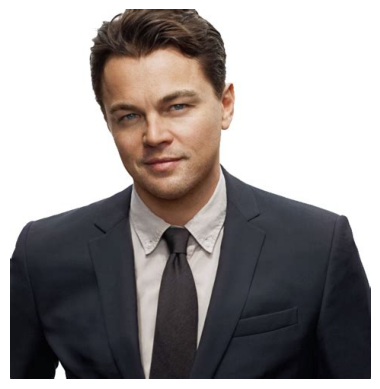

In [55]:
# ===========================
# 5. Checking Images Sample
# ===========================
train_dir = "/kaggle/working/celebrity_faces/train"


celeb_folder = os.listdir(train_dir)[0]
celeb_path = os.path.join(train_dir, celeb_folder)


img_name = os.listdir(celeb_path)[0]
img_path = os.path.join(celeb_path, img_name)

image = Image.open(img_path)
plt.imshow(image)
plt.axis("off")
plt.show()

In [56]:
# ===========================
# 6. Adding Noise
# ===========================
def add_noise(img, noise_std=0.05):
    """
    img: TensorFlow tensor with shape (H,W,C), values [0,1]
    Returns: (noisy_image, clean_image)
    """
    noisy_img = img + tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_std)
    noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0)  # keep in [0,1]
    return noisy_img, img


In [57]:
# Apply noise and batch datasets
train_ds = train_ds.map(add_noise).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(add_noise).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [59]:
# ===========================
# 7. U-Net Architecture
# ===========================
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_complex_dae(input_shape=(128,128,3)):
    inputs = layers.Input(shape=input_shape)

    # ===========================
    # Encoder
    # ===========================

    # Level 1
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)  # 128 -> 64

    # Level 2
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)  # 64 -> 32

    # Level 3
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)  # 32 -> 16

    # ===========================
    # BottleNeck
    # ===========================
    b = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(512, (3,3), activation='relu', padding='same')(b)

    # ===========================
    # Decoder
    # ===========================

    # Level 3
    u3 = layers.Conv2DTranspose(256, (3,3), strides=2, padding='same', activation='relu')(b)  # 16->32
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)

    # Level 2
    u2 = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(c4)  # 32->64
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c5)

    # Level 1
    u1 = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(c5)   # 64->128
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c6)

    # ===== Output =====
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(c6)

    model = Model(inputs, outputs)
    return model


complex_dae = build_complex_dae()
complex_dae.compile(optimizer='adam', loss='mse')
complex_dae.summary()


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_48[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_50[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_51[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_52[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_53[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_54[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_42 │ (None, 32, 32,    │  1,179,904 │ conv2d_55[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_53[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_56[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_43 │ (None, 64, 64,    │    295,040 │ conv2d_57[0][0] 

 Total params: 8,557,635 (32.64 MB)

 Trainable params: 8,557,635 (32.64 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# ===========================
# 7. Checkpoint & Training
# ===========================
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_cb = ModelCheckpoint(
    "best_complex_dae.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

EPOCHS = 20

History = complex_dae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb]
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - loss: 0.0557
Epoch 1: val_loss improved from inf to 0.00436, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - loss: 0.0552 - val_loss: 0.0044
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.0038
Epoch 2: val_loss improved from 0.00436 to 0.00400, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 384ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.0023
Epoch 3: val_loss improved from 0.00400 to 0.00162, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0013
Epoch 4: val_loss improved from 0.00162 to 0.00099, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - loss: 0.0013 - val_loss: 9.9381e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0011
Epoch 5: val_loss improved from 0.00099 to 0.00087, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - loss: 0.0011 - val_loss: 8.7113e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 8.6725e-04
Epoch 6: val_loss did not improve from 0.00087
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - loss: 8.6756e-04 - val_loss: 8.7659e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 8.9930e-04
Epoch 7: val_loss improved from 0.00087 to 0.00077, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - loss: 8.9902e-04 - val_loss: 7.7308e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 8.5931e-04
Epoch 8: val_loss did not improve from 0.00077
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - loss: 8.5980e-04 - val_loss: 0.0012
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 9.8581e-04
Epoch 9: val_loss improved from 0.00077 to 0.00074, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - loss: 9.8336e-04 - val_loss: 7.3989e-04
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 8.6622e-04
Epoch 10: val_loss improved from 0.00074 to 0.00071, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - loss: 8.6661e-04 - val_loss: 7.1226e-04
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 7.2333e-04
Epoch 11: val_loss did not improve from 0.00071
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - loss: 7.2351e-04 - val_loss: 7.4587e-04
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 7.2332e-04
Epoch 12: val_loss improved from 0.00071 to 0.00067, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - loss: 7.2312e-04 - val_loss: 6.7061e-04
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 7.8068e-04
Epoch 13: val_loss did not improve from 0.00067
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - loss: 7.8168e-04 - val_loss: 8.1038e-04
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 7.8126e-04
Epoch 14: val_loss improved from 0.00067 to 0.00065, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - loss: 7.8037e-04 - val_loss: 6.4983e-04
Epoch 15/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 7.0658e-04
Epoch 15: val_loss did not improve from 0.00065
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - loss: 7.0648e-04 - val_loss: 6.8463e-04
Epoch 16/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 6.6836e-04
Epoch 16: val_loss did not improve from 0.00065
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - loss: 6.6832e-04 - val_loss: 6.6112e-04
Epoch 17/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 6.4572e-04
Epoch 17: val_loss improved from 0.00065 to 0.00061, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - loss: 6.4553e-04 - val_loss: 6.0683e-04
Epoch 18/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 9.0253e-04
Epoch 18: val_loss did not improve from 0.00061
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - loss: 9.0364e-04 - val_loss: 6.7350e-04
Epoch 19/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 6.5219e-04
Epoch 19: val_loss did not improve from 0.00061
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - loss: 6.5202e-04 - val_loss: 6.1039e-04
Epoch 20/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 6.1892e-04
Epoch 20: val_loss improved from 0.00061 to 0.00059, saving model to best_complex_dae.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - loss: 6.1902e-04 - val_loss: 5.8994e-04


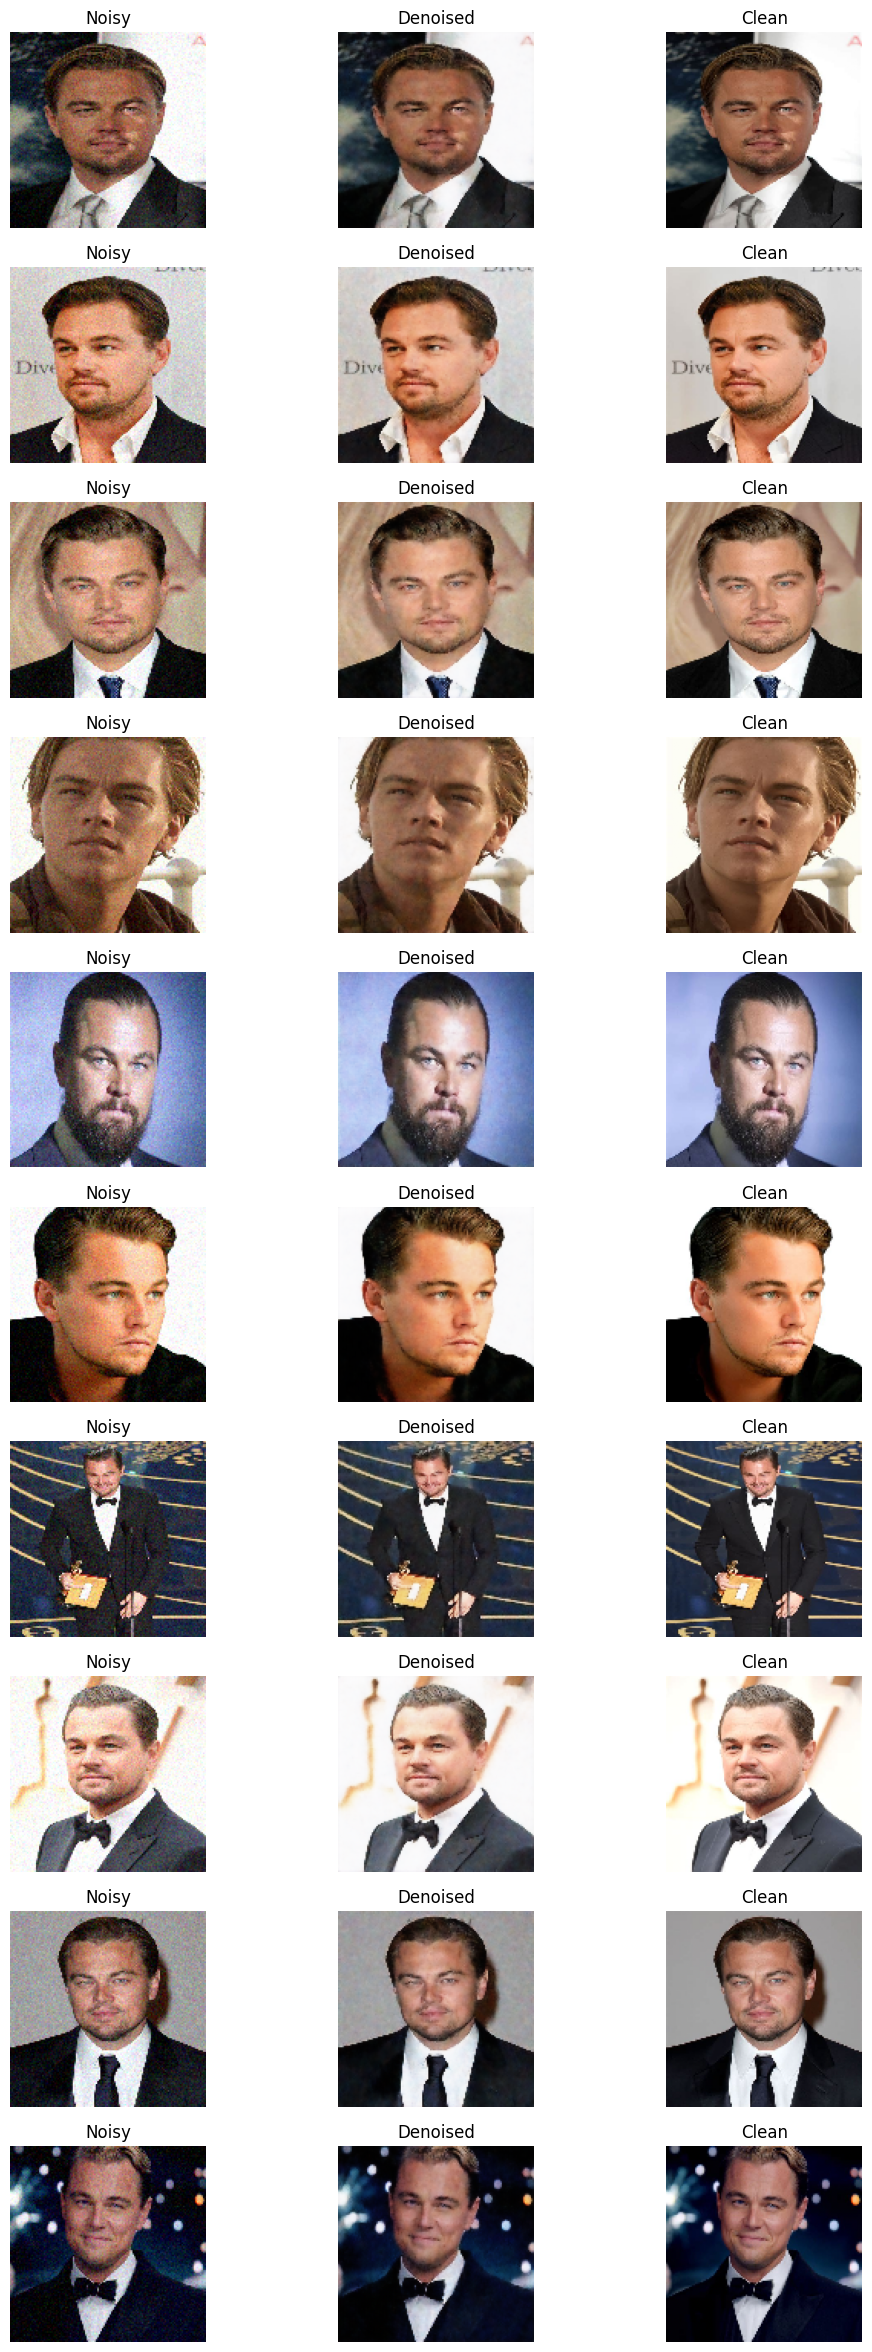

In [62]:
# ===========================
# 8. Visualizing Images
# ===========================

def show_results(model, dataset, num_images=5):
    for noisy, clean in dataset.take(1):
        denoised = model(noisy)
        plt.figure(figsize=(12, num_images*3))
        for i in range(num_images):
            # Noisy
            plt.subplot(num_images, 3, i*3+1)
            plt.imshow(noisy[i])
            plt.axis('off')
            plt.title("Noisy")
            # Denoised
            plt.subplot(num_images, 3, i*3+2)
            plt.imshow(denoised[i])
            plt.axis('off')
            plt.title("Denoised")
            # Clean
            plt.subplot(num_images, 3, i*3+3)
            plt.imshow(clean[i])
            plt.axis('off')
            plt.title("Clean")
        plt.show()

show_results(complex_dae, val_ds, num_images=10)